In [1]:
from torch.utils.data import DataLoader
from src.smalldiffusion import Swissroll, TimeInputMLP, ScheduleLogLinear, training_loop, samples
import numpy as np
import matplotlib.pyplot as plt

/home/hepe00001/anaconda3/envs/generative_diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

In [3]:
# Define the dataset to be used
# 100 instances and each instance is a 2D tensor
dataset  = Swissroll(np.pi/2, 5*np.pi, 100) 
loader = DataLoader(dataset, batch_size=2048)

In [4]:
# input has 4 dimensions and output has 2 dimensions
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)


TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_224152/2456428996.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_t$')


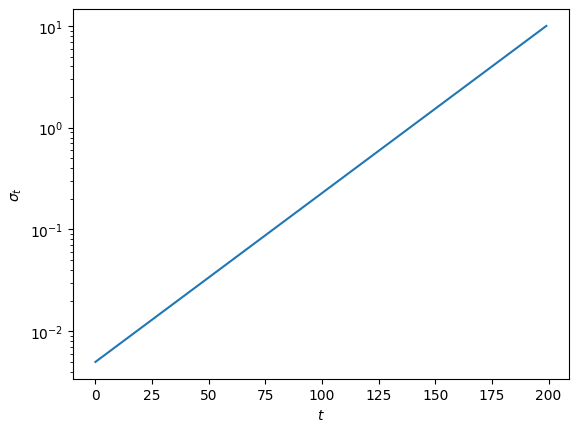

In [5]:
# the sigma values (or variance) in the context of diffusion models typically correspond to 
# the amount of noise added at each time step during the forward diffusion process.
# for this case, the lowest sigma (noise) is 0.005 and there are 200 sigma values
# that will gradually be added during the forward process
schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_224152/1342756347.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
/tmp/ipykernel_224152/1342756347.py:17: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')


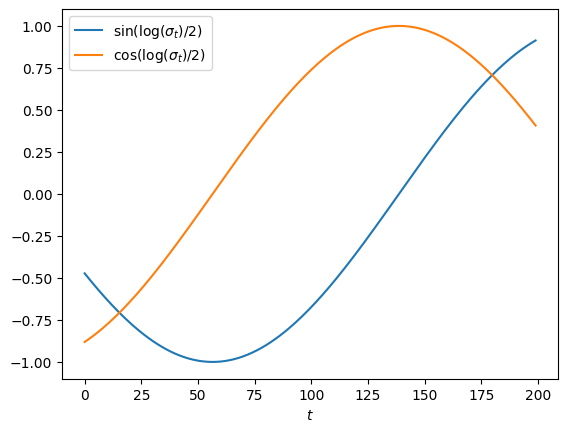

In [6]:
from src.smalldiffusion.model import get_sigma_embeds
"""
Sigma Embeddings
The sigma embeddings transform the sigma values into a form that the model can better utilize. 
This is done using sine and cosine functions of the logarithm of sigma. Here's why this is useful:

Purpose: The goal is to provide the model with a richer representation of the sigma value, 
         which represents the noise level. Instead of directly using sigma, which might 
         have a large dynamic range, the embeddings provide a bounded and periodic representation.

Transformation: By using sine and cosine of the logarithm of sigma, we capture both the scale (logarithm)
                and periodicity (sine and cosine) properties. This can help the model to learn more effectively, 
                especially when sigma varies widely.
"""
sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [ ]:
trainer  = training_loop(loader, model, schedule, epochs=5000)
losses   = [ns.loss.item() for ns in trainer]

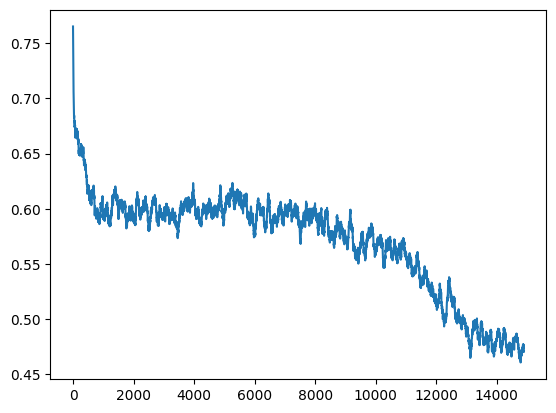

In [20]:
# plot the loss
plt.plot(moving_average(losses, 100))
plt.show()

1


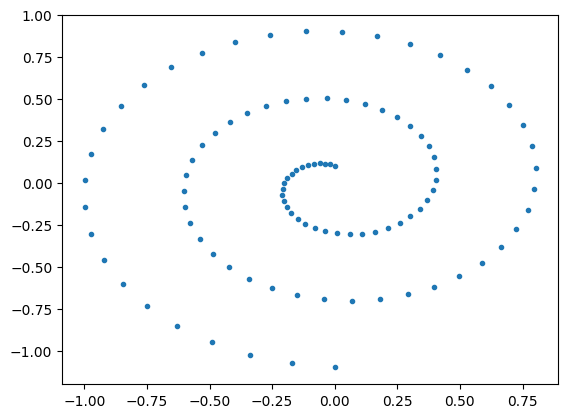

In [21]:
# all the instances in the data combined (plotted) together results
# in this spiral shape. This is essentially the noiseless data that 
# represents the dataset
plot_batch(next(iter(loader)))

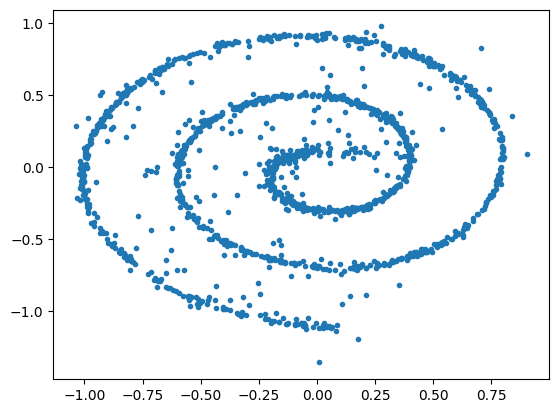

In [22]:
#
*xt, x0  = samples(model, schedule.sample_sigmas(20), batchsize=1500, gam=2)
plot_batch(x0)

In [23]:
print((x0))

tensor([[ 0.0537,  0.0828],
        [ 0.6023,  0.5988],
        [-0.5585, -0.3470],
        ...,
        [-0.8656,  0.4359],
        [-0.5256,  0.2153],
        [-0.3071, -0.5828]], device='cuda:0')


In [ ]:
# Collect samples
all_samples = [sample for sample in sample_generator]

# Convert to numpy for visualization
all_samples_np = [s.detach().cpu().numpy() for s in all_samples]

# Plot the results
plt.figure(figsize=(10, 8))
for i, sample in enumerate(all_samples_np):
    plt.scatter(sample[:, 0], sample[:, 1], label=f'Step {i}')
plt.legend()
plt.title('Generated Samples Over Steps')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()